# Exploratory data analysis for representations

In [1]:
import os
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import scanpy as sc
import anndata as ad

from torch.utils.data import DataLoader, Subset, TensorDataset
from matplotlib.pyplot import rc_context

from cl_explain.encoders.simclr.resnet_wider import resnet50x1

In [2]:
imagenette_path = "/projects/leelab/data/image/imagenette2/val"
imagenet_path = "/projects/leelab/data/image/imagenet"
encoder_path = "/projects/leelab/cl-explainability/encoders/simclr"
device = "cuda:7"

In [3]:
dataset = torchvision.datasets.ImageFolder(
    imagenette_path,
    transform=transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    ),
)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [4]:
# Map Imagenette integer label to Imagenet integer label.
imagenette_int_to_label_map = dataset.find_classes(imagenette_path)[1]
imagenette_int_to_label_map = {
    val: key
    for key, val in imagenette_int_to_label_map.items()
}

imagenet_label_to_int_map = {}
with open(os.path.join(imagenet_path, "LOC_synset_mapping.txt")) as handle:
    lines = handle.readlines()
for i, line in enumerate(lines):
    label = line.strip().split(" ", 1)[0]
    imagenet_label_to_int_map[label] = i
    
imagenette_to_imagenet_map = {}
for int_key, label in imagenette_int_to_label_map.items():
    imagenette_to_imagenet_map[int_key] = imagenet_label_to_int_map[label]

In [5]:
# Load a pre-trained SimCLR encoder.
encoder = resnet50x1()
state_dict_path = os.path.join(encoder_path, "resnet50-1x.pth")
state_dict = torch.load(state_dict_path, map_location="cpu")
encoder.load_state_dict(state_dict["state_dict"])
encoder.to(device)
encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn

## Get representations and classification outputs

In [6]:
rep_list = []
pred_list = []
target_list = []
for img, target in data_loader:
    img, target = img.to(device), target.to(device)
    rep = encoder(img, apply_eval_head=False)
    out = encoder.fc(rep).softmax(dim=1)
    pred = out.argmax(dim=1)
    
    rep_list.append(rep.detach().cpu())
    pred_list.append(pred.detach().cpu())
    target_list.append(target.detach().cpu())

In [7]:
reps = torch.cat(rep_list)
preds = torch.cat(pred_list)
targets = torch.cat(target_list)
imagenet_targets = [imagenette_to_imagenet_map[int(target)] for target in targets]
imagenet_targets = torch.Tensor(imagenet_targets)

## Top-1 accuracy

In [8]:
acc = ((preds == imagenet_targets) * 1.0).mean()
print(acc.numpy())

0.7854777


## Visualize representation clusters

In [9]:
target_pd = pd.DataFrame({"target": targets.numpy()})
target_pd["target"] = target_pd["target"].astype(str)

In [10]:
rep_adata = ad.AnnData(X=reps.numpy(), obs=target_pd)
sc.pp.neighbors(rep_adata)
sc.tl.umap(rep_adata)
sc.pp.pca(rep_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/homes/gws/clin25/miniconda3/envs/cl-explain-env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


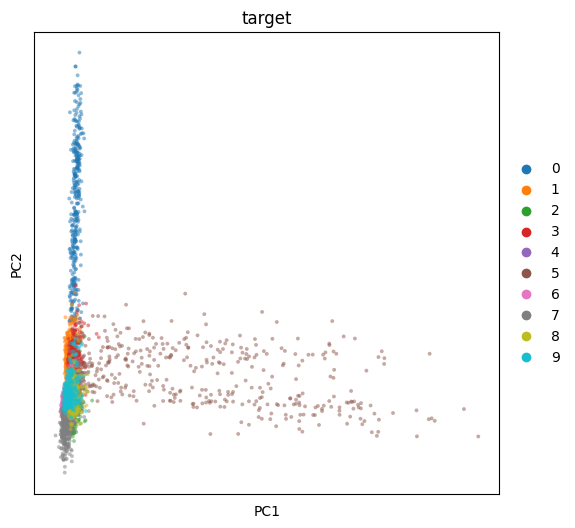

In [34]:
with rc_context({"figure.figsize": (6, 6)}):
    sc.pl.pca(rep_adata, color="target", alpha=0.5)
    plt.show()

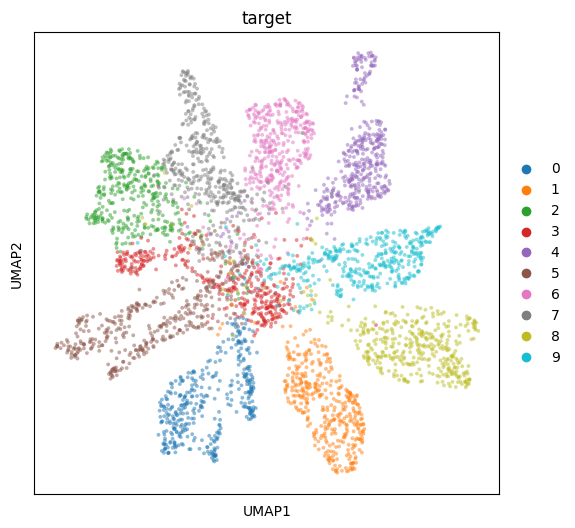

In [12]:
with rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(rep_adata, color="target", alpha=0.5)
    plt.show()

## Statistics of representations

In [13]:
def compute_sparsity(reps):
    """Computes sparsity of each representation."""
    return (reps == 0).sum(dim=1) / reps.size(1)


def compute_l2_norm(reps):
    """Computes L2 norm of each representation."""
    return (reps ** 2).sum(dim=1)


def compute_pairwise_l2_dist(x, y):
    """Computes pairwise L2 distance between two representation sets."""
    return torch.norm(x.unsqueeze(1) - y.unsqueeze(0), dim=-1)


def summarize(values):
    """Provides summary statistics."""
    val_max = values.max().cpu().numpy()
    val_min = values.min().cpu().numpy()
    val_mean = values.mean().cpu().numpy()
    val_median = values.median().cpu().numpy()
    return pd.DataFrame(
        {
            "max": [val_max],
            "min": [val_min],
            "mean": [val_mean],
            "median": [val_median],
        }
    )

def get_rep_stats(reps):
    sparsity = summarize(compute_sparsity(reps))
    l2_norm = summarize(compute_l2_norm(reps))
    l2_dist = summarize(compute_pairwise_l2_dist(reps, reps))
    
    sparsity["metric"] = ["sparsity"]
    l2_norm["metric"] = ["l2_norm"]
    l2_dist["metric"] = ["l2_dist"]
    
    rep_stats = pd.concat(
        [sparsity, l2_norm, l2_dist], ignore_index=True
    )
    return rep_stats[["metric", "min", "median", "mean", "max"]]

In [14]:
rep_stats = get_rep_stats(reps)
print(rep_stats)

     metric         min     median       mean        max
0  sparsity  0.24169922  0.5180664  0.5254308  0.7607422
1   l2_norm    47.44151  169.35555  209.56857  1755.6469
2   l2_dist         0.0  16.116062  17.033838   48.70612


In [15]:
unique_targets = targets.unique().numpy()
for target in unique_targets:
    target_rep_stats = get_rep_stats(reps[targets == target])
    print("Class:", target)
    print(target_rep_stats)
    print("")

Class: 0
     metric         min      median        mean        max
0  sparsity  0.27197266  0.47802734  0.47247204  0.6118164
1   l2_norm    74.01333    257.9752   271.15054   571.2641
2   l2_dist         0.0   14.983062   15.056035  27.468325

Class: 1
     metric         min      median        mean         max
0  sparsity  0.26953125   0.4892578  0.48748145  0.64501953
1   l2_norm    73.32291    187.3259    205.4407    810.4033
2   l2_dist         0.0  14.1176605  14.4530945   30.815502

Class: 2
     metric         min      median       mean        max
0  sparsity  0.34521484  0.58496094   0.581175  0.7373047
1   l2_norm    71.78038   161.98886  172.71924   407.2521
2   l2_dist         0.0   13.261304  13.371717  23.803205

Class: 3
     metric         min     median        mean         max
0  sparsity  0.24169922    0.46875  0.47208953  0.70410156
1   l2_norm    69.90714   130.1459   139.32521   508.81717
2   l2_dist         0.0  12.253968   12.365897   24.405336

Class: 4
     me

## Statistics of black image representation

In [16]:
black_img = torch.zeros(1, 3, 224, 224).to(device)
black_rep = encoder(black_img).detach().cpu()

In [17]:
black_rep_stats = get_rep_stats(black_rep)
print(black_rep_stats)

     metric        min     median       mean        max
0  sparsity  0.6225586  0.6225586  0.6225586  0.6225586
1   l2_norm  16.677784  16.677784  16.677784  16.677784
2   l2_dist        0.0        0.0        0.0        0.0


In [18]:
# L2 distance with original images.
black_dist_stats = summarize(compute_l2_norm(black_rep - reps))
print(black_dist_stats)

         max      min       mean     median
0  1724.9321  37.5745  189.18834  148.66728


## Statistics of white image representation

In [19]:
white_img = torch.ones(1, 3, 224, 224).to(device)
white_rep = encoder(white_img).detach().cpu()

In [20]:
white_rep_stats = get_rep_stats(white_rep)
print(white_rep_stats)

     metric        min     median       mean        max
0  sparsity  0.8803711  0.8803711  0.8803711  0.8803711
1   l2_norm  26.626276  26.626276  26.626276  26.626276
2   l2_dist        0.0        0.0        0.0        0.0


In [21]:
# L2 distance with original images.
white_dist_stats = summarize(compute_l2_norm(white_rep - reps))
print(white_dist_stats)

         max        min      mean     median
0  1748.4203  39.235756  206.4767  166.19841


## Statistics of Gaussian noise image representations

In [22]:
gaussian_imgs = torch.randn(reps.shape[0], 3, 224, 224)
gaussian_data_loader = DataLoader(
    TensorDataset(gaussian_imgs), batch_size=32
)

gaussian_reps = []
for (img,) in gaussian_data_loader:
    img = img.to(device)
    gaussian_reps.append(encoder(img).detach().cpu())
gaussian_reps = torch.cat(gaussian_reps)

In [23]:
guassian_rep_stats = get_rep_stats(gaussian_reps)
print(guassian_rep_stats)

     metric         min      median       mean         max
0  sparsity  0.95410156  0.96728516  0.9671039  0.97314453
1   l2_norm    1454.552   1816.8815  1819.2502    2209.763
2   l2_dist         0.0    3.690027  3.8420641   13.293672


In [24]:
# L2 distance with original images.
gaussian_dist_stats = summarize(compute_l2_norm(gaussian_reps - reps))
print(gaussian_dist_stats)

        max        min       mean     median
0  3451.019  1521.1409  1922.5533  1901.0754


## Comparison of original vs. blurred images

In [25]:
blur = transforms.GaussianBlur(21, sigma=5).to(device)

In [26]:
for img, _ in data_loader:
    img = img.to(device)
    blurred_img = blur(img)
    break
img = img.cpu()
blurred_img = blurred_img.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


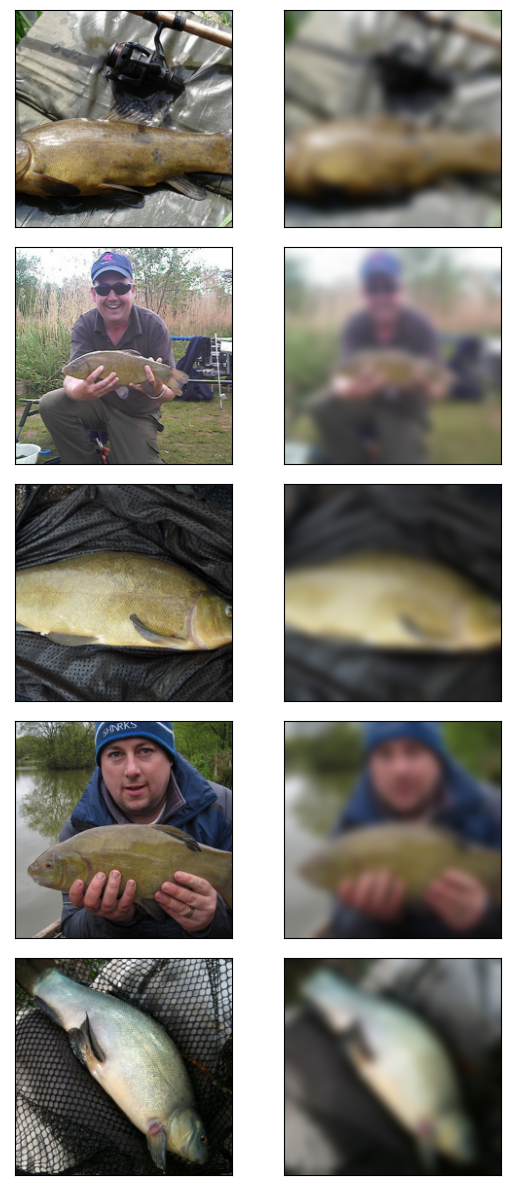

In [27]:
num_imgs = 5
fig, axes = plt.subplots(num_imgs, 2, figsize=(6, 12))
for i in range(num_imgs):
    axes[i, 0].imshow(img[i].permute(1, 2, 0))
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    
    axes[i, 1].imshow(blurred_img[i].permute(1, 2, 0))
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
plt.tight_layout()
plt.show()

In [28]:
blurred_rep_list = []
for img, _ in data_loader:
    img = img.to(device)
    img = blur(img)
    rep = encoder(img, apply_eval_head=False)
    blurred_rep_list.append(rep.detach().cpu())

In [29]:
blurred_reps = torch.cat(blurred_rep_list)

In [30]:
blurred_rep_stats = get_rep_stats(blurred_reps)
print(blurred_rep_stats)

     metric         min      median       mean         max
0  sparsity  0.39892578  0.58154297   0.585296  0.85058594
1   l2_norm   51.608723   125.91287  133.97853    456.1154
2   l2_dist         0.0    9.315268   9.516823   23.109322


In [31]:
comparison_data_loader = DataLoader(
    TensorDataset(reps, blurred_reps),
    batch_size=32,
    shuffle=False,
)

In [32]:
blur_dist_list = []
for rep, blurred_rep in comparison_data_loader:
    blur_dist_list.append(compute_l2_norm(rep - blurred_rep))
blur_dists = torch.cat(blur_dist_list)
blur_dist_stats = summarize(blur_dists)

In [33]:
print(blur_dist_stats)

         max       min       mean     median
0  1702.1282  35.31511  220.23248  186.36215
